
=== Running for T = 5 ===


Reverse Diffusion Progress: 100%|██████████| 19/19 [00:00<00:00, 4355.69it/s]


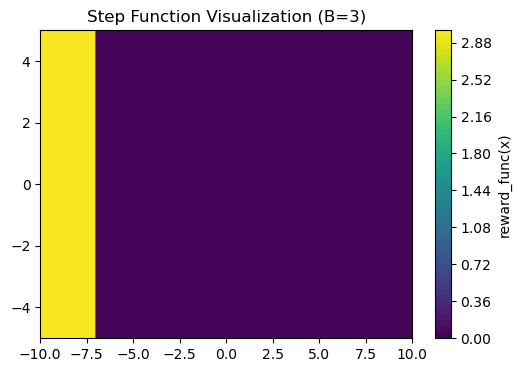

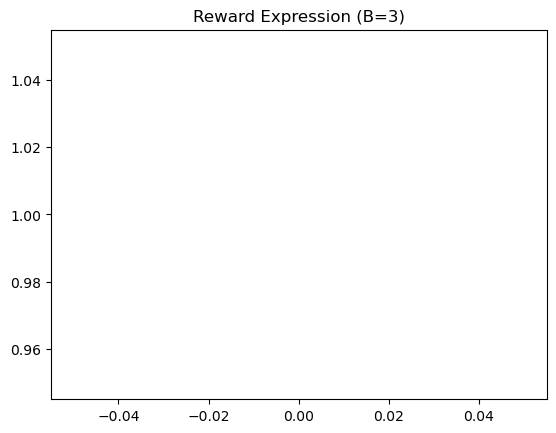

Building ValueEstimate...
[Epoch 01] avg MSE: 1.0999


Reverse Diffusion Progress: 100%|██████████| 19/19 [30:31<00:00, 96.38s/it]
Generating Trajectories: 5013it [54:44,  1.53it/s]                             
Generating Trajectories:   0%|          | 0/5000 [00:00<?, ?it/s]/var/folders/zk/bk5jkrk11398bfvxps9gbhw00000gn/T/ipykernel_44270/67835576.py:92: RuntimeWarning: invalid value encountered in log
  return np.log(val_ensemble.predict(x, t_arr))
Generating Trajectories:   7%|▋         | 369/5000 [16:31:33<207:24:06, 161.23s/it]  


KeyboardInterrupt: 

In [ ]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

from mixture_lower import Mixture
from guided_models import Diffusion, GuidedDiffusion, LastStepDiffusion
from mixture_guidance import MixtureSpecificGuidance
from value_estimator import ValueEstimate
from tv_estimator import tv_bounds_classifier

results = {}

# Diffusion parameters

B = 3

for T in [10, 20, 40, 80, 160]:
    n = T
    print(f"\n=== Running for T = {T} ===")
    t_vals = np.arange(1, n+1)
    c, delta = 4, 0.02
    inner = delta * (1 + c * np.log(n) / n)**t_vals
    alpha_t = 1 - (c * np.log(n) / n) * np.minimum(inner, 1)
    alpha_t[0] = 1 - delta
    d = 2

    # Mixture setup
    mu_0 = np.array([[5, 0], [-5, 0]])
    var_0 = np.eye(d)
    pi_0 = np.array([0.95, 0.05])
    pi_0 /= np.sum(pi_0)
    dist0 = Mixture(mu_0, var_0, pi_0)

    num_training_trials = int(T**2*50_000/20)
    num_training_trials = 1
    diffusion = Diffusion(dist0, alpha_t, S=num_training_trials)
    X = diffusion.calc_samples()
    k = 2
    # def reward_func(x):
    #     x0 = np.asarray(x)[..., 0]
    #     return B / (1 + np.exp(k * (x0 + 8)))
    def reward_func_hard(x):
        x0 = np.asarray(x)[..., 0]
        return np.where(x0 < -7, B, 0)
    L_r = B * k / 4

    # Plot reward function
    x1 = np.linspace(-10, 10, 200)
    x2 = np.linspace(-5, 5, 200)
    X1, X2 = np.meshgrid(x1, x2)
    Z = reward_func_hard(np.stack([X1, X2], axis=-1))
    plt.figure(figsize=(6, 4))
    plt.contourf(X1, X2, Z, levels=50, cmap='viridis')
    plt.colorbar(label='reward_func(x)')
    plt.title(f'Step Function Visualization (B={B})')
    plt.show()

    expr = np.exp(reward_func_hard(X[:, -1, :]))
    plt.plot(expr)
    plt.title(f"Reward Expression (B={B})")
    plt.show()

    # Train value estimator
    val_ensemble = ValueEstimate(X, expr, [128, 500, 500])
    val_ensemble.train(epochs = 1)

    # Guided sampling
    guided_per = GuidedDiffusion(
        dist0, alpha_t,
        lambda x, t: np.log(np.clip(val_ensemble.predict(x, t), np.e**(-B), np.e**B)),
        upper_bound=B, temperature=1, S=5000
    )
    X_per = guided_per.calc_samples()

    guided_true = LastStepDiffusion(
        dist0, alpha_t,
        lambda x: np.log(np.clip(reward_func_hard(x), np.e**(-B), np.e**B)),
        upper_bound=B, S=5000
    )
    X_guided_true = guided_true.calc_samples()

    def func(x, val_ensemble):
        x = np.expand_dims(x, axis=0)
        t_arr = np.array([T - 1])
        return np.log(val_ensemble.predict(x, t_arr))

    guided_last = LastStepDiffusion(
        dist0, alpha_t,
        lambda x: func(np.array(x), val_ensemble),
        upper_bound=B, S=5000
    )
    X_guided_last = guided_last.calc_samples()

    guided_msg = MixtureSpecificGuidance(dist0, alpha_t, reward_func_hard, L_r = L_r, value_fn=lambda t, x: (np.log(np.clip(val_ensemble.predict(x, t), np.e**(-B), np.e**B))),   S = 5000, delta = 0.01, use_trace = False)
    X_guided_msg = guided_msg.calc_samples()

    num_steps_msg = guided_msg.num_steps
    num_steps_per = guided_per.num_steps
    num_steps_true = guided_true.num_steps
    num_steps_last = guided_last.num_steps

    results[T] = {
        "X_guided_msg": X_guided_msg,
        "X_per": X_per,
        "X_guided_true": X_guided_true,
        "X_guided_last": X_guided_last,
        "num_steps_msg": num_steps_msg,
        "num_steps_per": num_steps_per,
        "num_steps_true": num_steps_true,
        "num_steps_last": num_steps_last,
    }

    # Example: plot histograms for each B
    plt.figure(figsize=(8, 6))
    plt.hist(X[:, -1, 0], bins=100, alpha=0.5, color='green', label='H.P. Guided (per step)')
    plt.hist(X_guided_last[:, -1, 0], bins=100, alpha=0.5, color='blue', label='Guided (last step)')
    plt.hist(X_guided_true[:, -1, 0], bins=100, alpha=0.5, color='orange', label='True optimal')
    plt.xlabel('First Coordinate')
    plt.ylabel('Count')
    plt.title(f'Superimposed Histogram of Final Step Samples (B={B})')
    plt.legend()
    plt.tight_layout()
    plt.show()

# After the loop, you can analyze or plot results for all B values
# for B in results:
#     print(f"\nB = {B}")
#     print("TV (per step):", results[B]["tv_per"]["tv_lb"])
#     print("TV (true):", results[B]["tv_true"]["tv_lb"])
#     print("TV (last step):", results[B]["tv_last"]["tv_lb"])
#     print("TV (unguided):", results[B]["tv_unguided"]["tv_lb"])

In [4]:
results

{1: {'tv_per': {'n_star': 5000,
   'n_hat': 5000,
   'd': 2,
   'test_error': 0.494,
   'tv_lower_bound': 0.01200000000000001,
   'tv_plugin': 0.010697827237199597,
   'kl_star_hat': 0.0005910101019355169,
   'kl_hat_star': 0.0005799380103554125,
   'tv_upper_bound': 0.01702847630229159},
  'tv_true': {'n_star': 5000,
   'n_hat': 5000,
   'd': 2,
   'test_error': 0.4883333333333333,
   'tv_lower_bound': 0.023333333333333428,
   'tv_plugin': 0.023753756722530803,
   'kl_star_hat': 0.0026297974811779934,
   'kl_hat_star': 0.0016784398058308906,
   'tv_upper_bound': 0.02896929241309572},
  'tv_last': {'n_star': 5000,
   'n_hat': 5000,
   'd': 2,
   'test_error': 0.4836666666666667,
   'tv_lower_bound': 0.03266666666666662,
   'tv_plugin': 0.01679998436785967,
   'kl_star_hat': 0.001502262372250371,
   'kl_hat_star': 0.001315218428135603,
   'tv_upper_bound': 0.025643892334585278},
  'tv_unguided': {'n_star': 5000,
   'n_hat': 5000,
   'd': 2,
   'test_error': 0.487,
   'tv_lower_bound': 0

In [ ]:
import pickle

with open("results_vary_T.pkl", "wb") as f:
    pickle.dump(results, f)
print("Results saved to results_vary_B.pkl")

Results saved to results_vary_B.pkl


In [ ]:
import pickle

with open("results_vary_T.pkl", "rb") as f:
    results_loaded = pickle.load(f)

# Now you can access results as before, e.g.:
print(results_loaded.keys())
print(results_loaded[1].keys())

dict_keys([1, 3, 5])
dict_keys(['tv_per', 'tv_true', 'tv_last', 'tv_unguided', 'X_guided_msg', 'X_per', 'X_guided_true', 'X_guided_last', 'X_unguided', 'num_steps_msg', 'num_steps_per', 'num_steps_true', 'num_steps_last'])


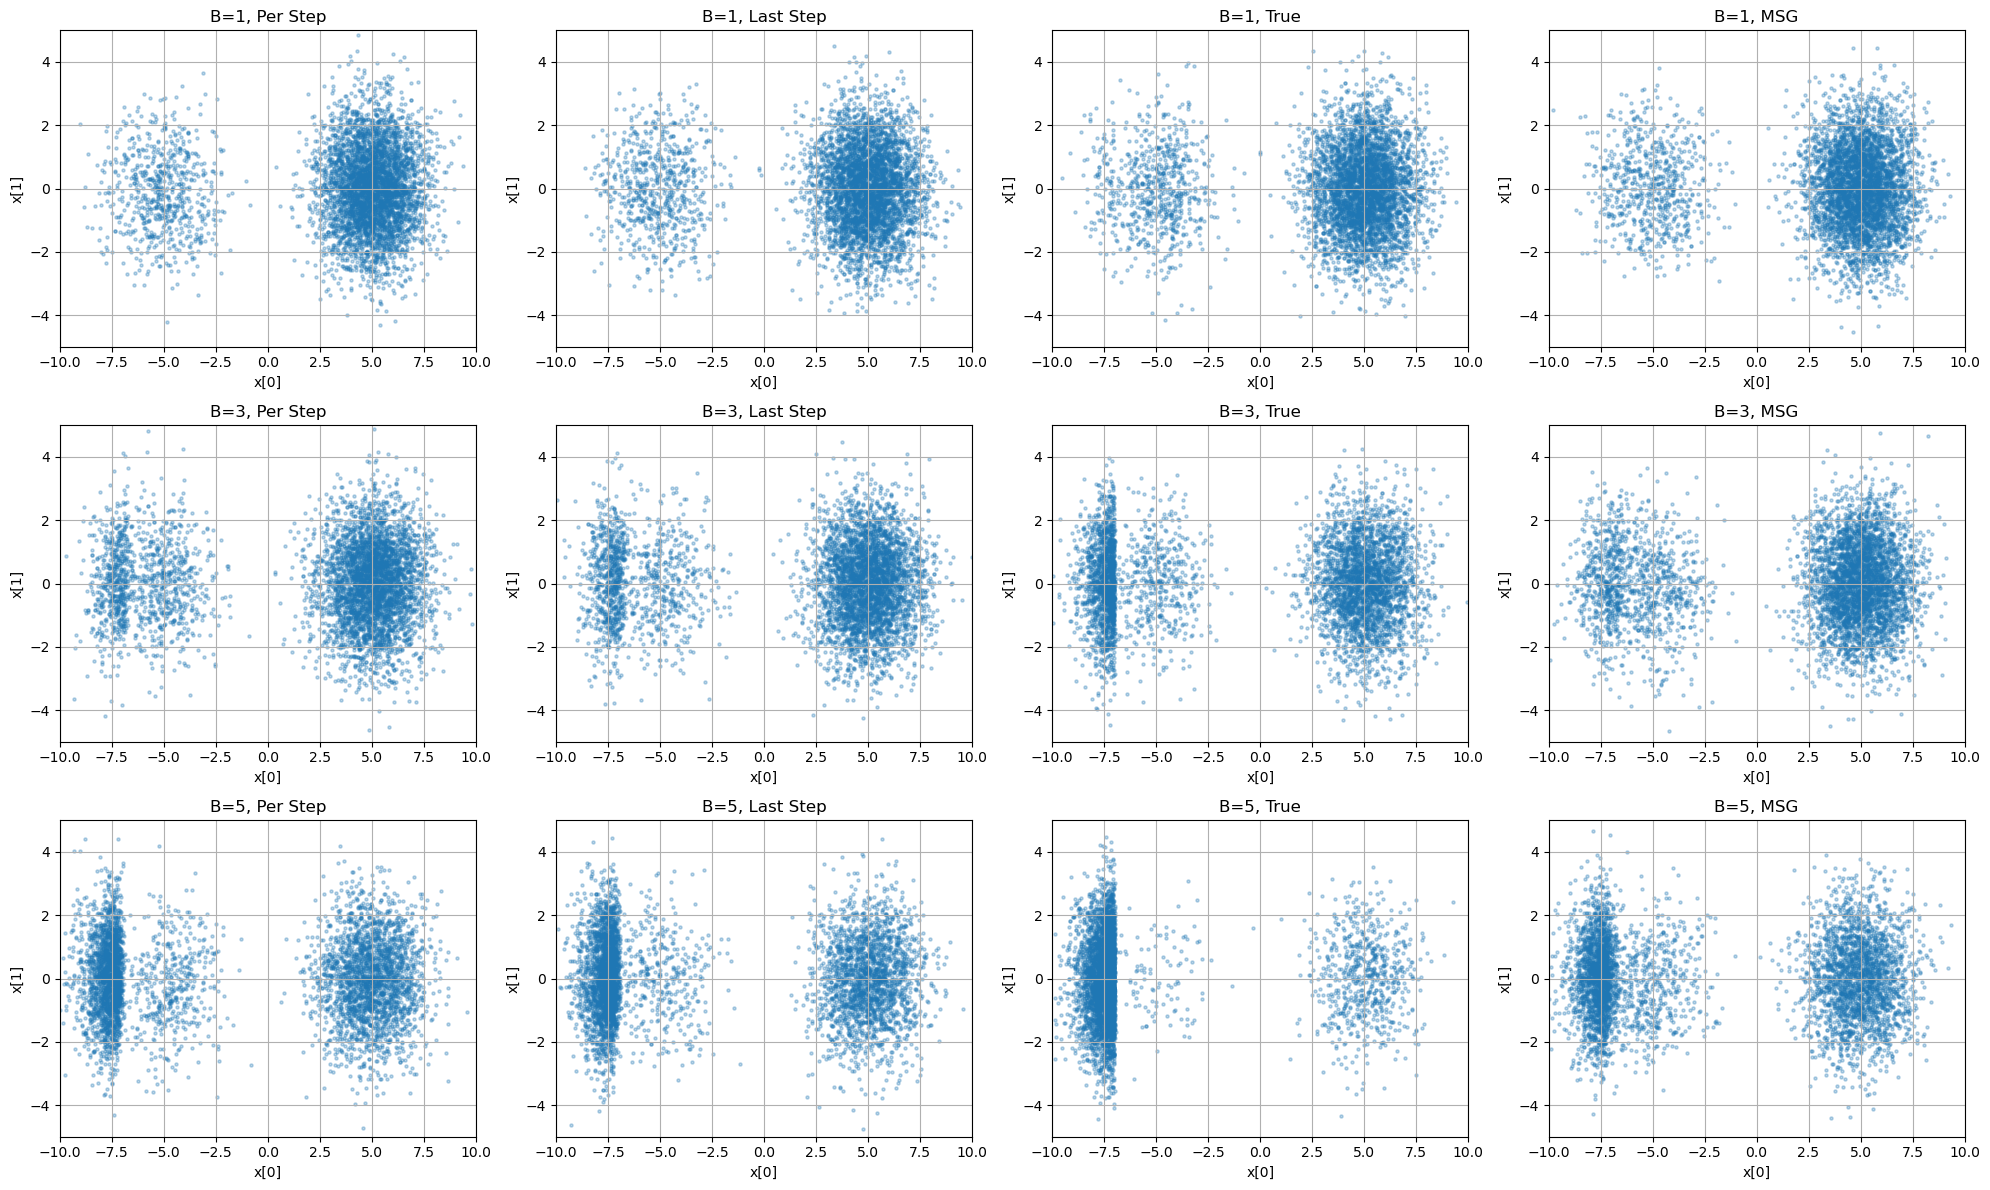

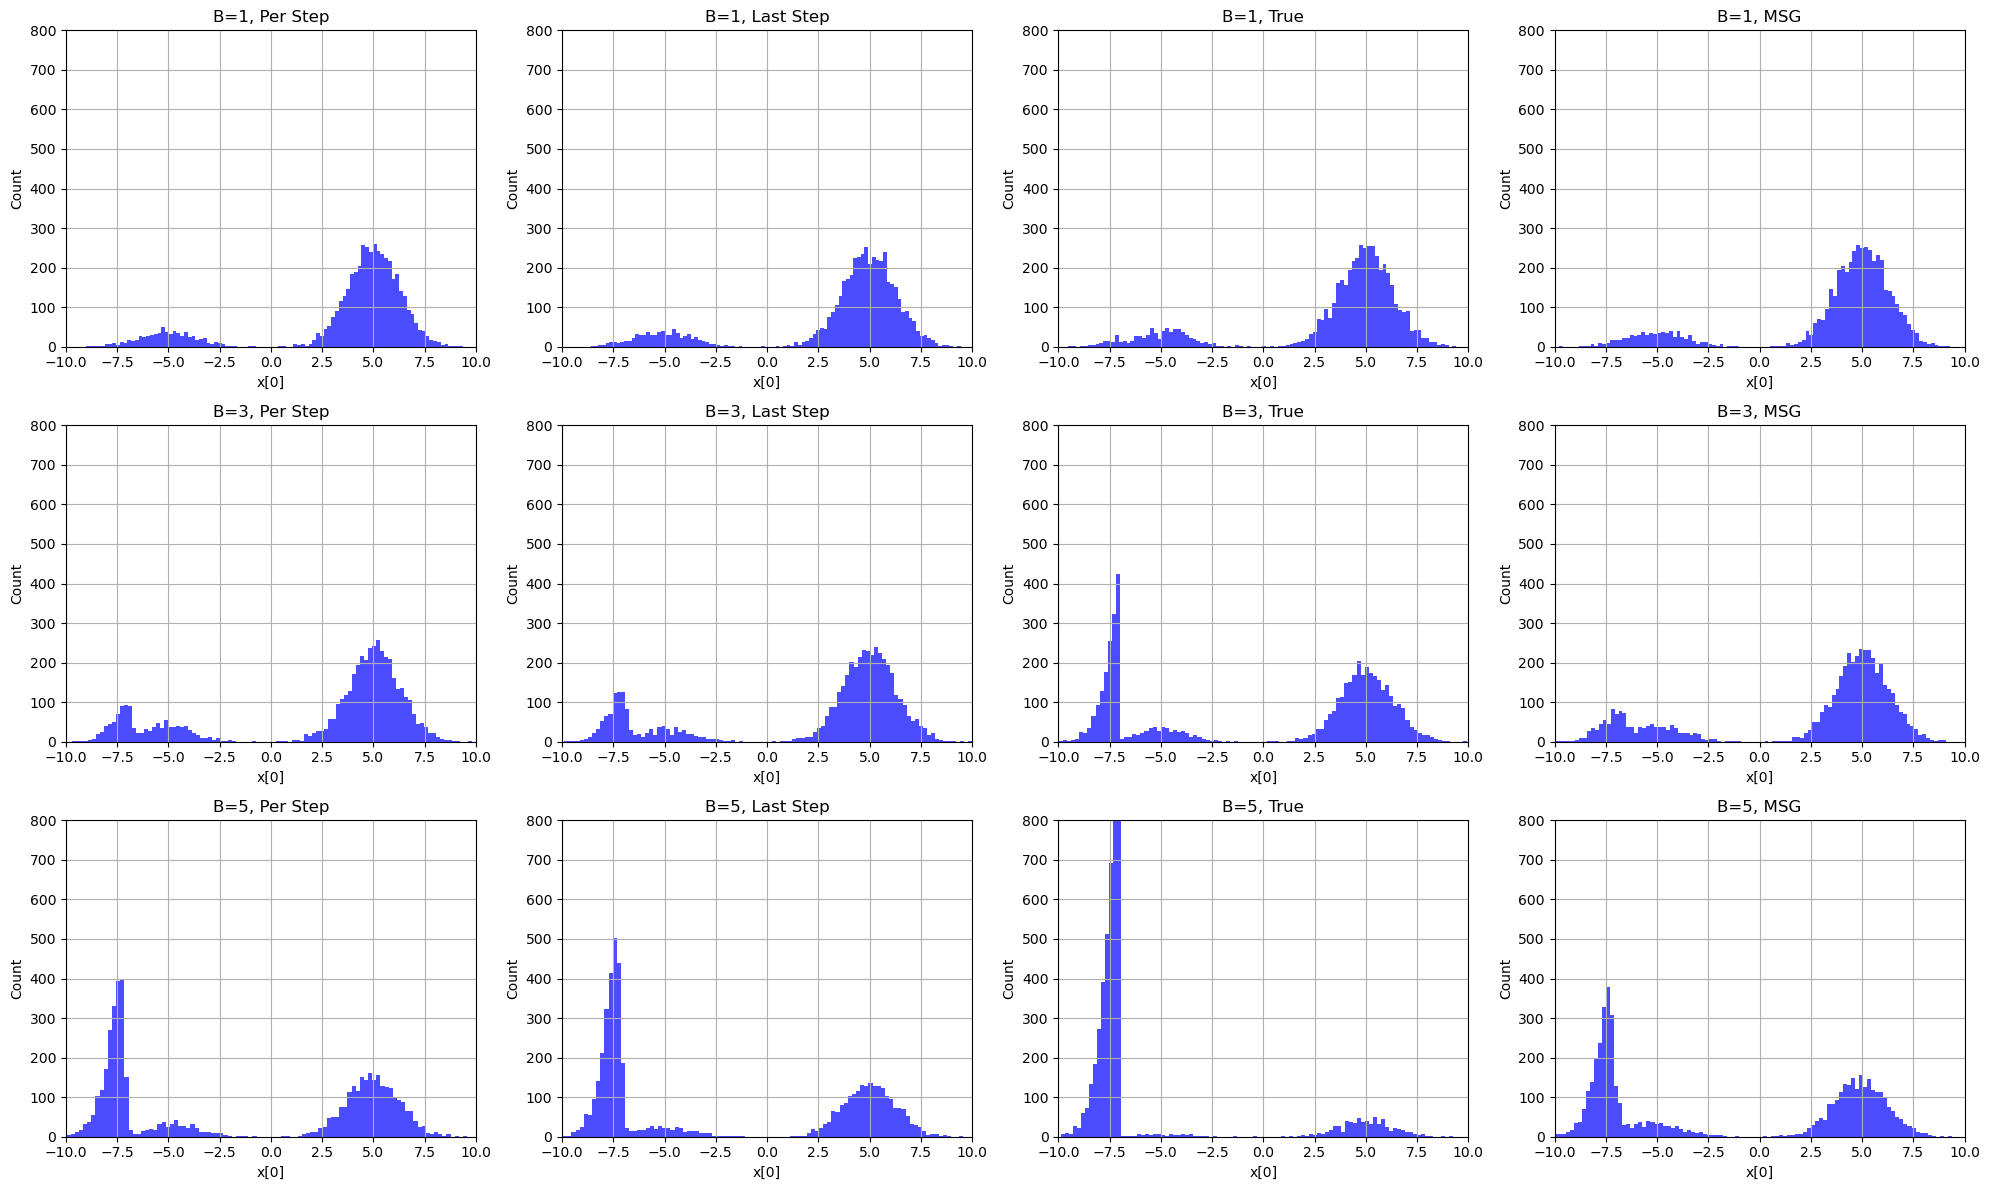

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
Bs = sorted(results_loaded.keys())
guided_keys = ["X_per", "X_guided_last", "X_guided_true", "X_guided_msg"]
guided_labels = ["Per Step", "Last Step", "True", "MSG"]

# Set common limits for scatter plots
xlim = (-10, 10)
ylim = (-5, 5)

for i, B in enumerate(Bs):
    for j, key in enumerate(guided_keys):
        X_samples = results_loaded[B][key][:, -1, :]
        axes[i, j].scatter(X_samples[:, 0], X_samples[:, 1], s=5, alpha=0.3)
        axes[i, j].set_title(f"B={B}, {guided_labels[j]}")
        axes[i, j].set_xlabel("x[0]")
        axes[i, j].set_ylabel("x[1]")
        axes[i, j].set_xlim(xlim)
        axes[i, j].set_ylim(ylim)
        axes[i, j].grid(True)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
# Set common limits for histograms
hist_xlim = (-10, 10)
hist_ylim = (0, 800)  # Adjust as needed for your data

for i, B in enumerate(Bs):
    for j, key in enumerate(guided_keys):
        X_samples = results_loaded[B][key][:, -1, 0]
        axes[i, j].hist(X_samples, bins=100, alpha=0.7, color='blue')
        axes[i, j].set_title(f"B={B}, {guided_labels[j]}")
        axes[i, j].set_xlabel("x[0]")
        axes[i, j].set_ylabel("Count")
        axes[i, j].set_xlim(hist_xlim)
        axes[i, j].set_ylim(hist_ylim)
        axes[i, j].grid(True)

plt.tight_layout()
plt.show()

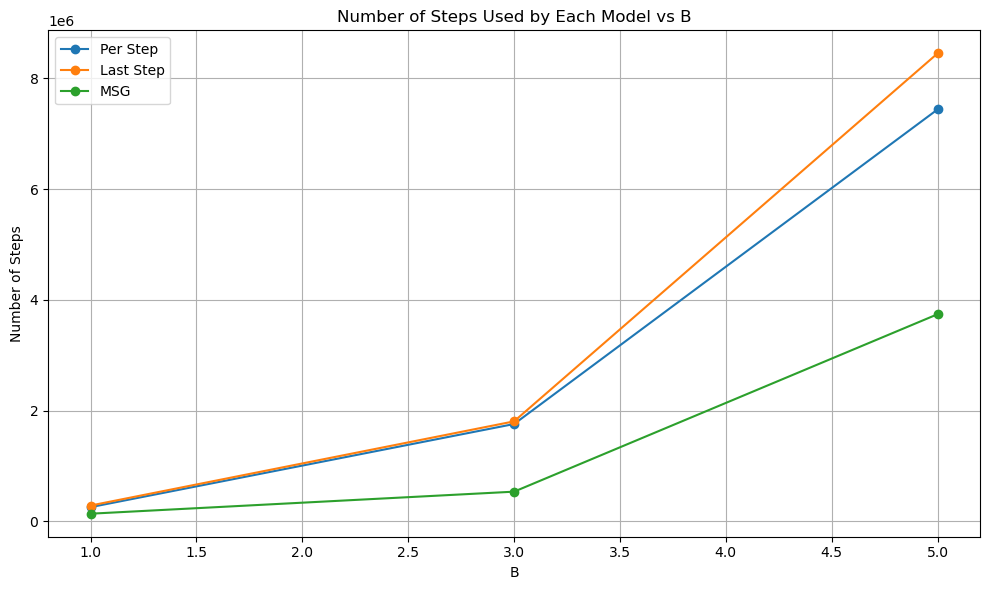

In [11]:
plt.figure(figsize=(10, 6))
Bs = sorted(results_loaded.keys())
num_steps_per = [results_loaded[B]["num_steps_per"] for B in Bs]
num_steps_last = [results_loaded[B]["num_steps_last"] for B in Bs]
num_steps_true = [results_loaded[B]["num_steps_true"] for B in Bs]
num_steps_msg = [results_loaded[B]["num_steps_msg"] for B in Bs]

plt.plot(Bs, num_steps_per, marker='o', label='Per Step')
plt.plot(Bs, num_steps_last, marker='o', label='Last Step')
# plt.plot(Bs, num_steps_true, marker='o', label='True')
plt.plot(Bs, num_steps_msg, marker='o', label='MSG')

plt.xlabel('B')
plt.ylabel('Number of Steps')
plt.title('Number of Steps Used by Each Model vs B')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()